# ELECTRICITY BILL PREDICTION
# RECS 2020 Data Cleaning & Feature Engineering

## Imports and Setup

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## Load RECS 2020 Data

In [47]:
df = pd.read_csv("recs2020_public_v7.csv")

print(f"Dataset loaded successfully")
print(f"Shape: {df.shape[0]:,} households × {df.shape[1]} features")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

display(df.head())

Dataset loaded successfully
Shape: 18,496 households × 799 features
Memory usage: 119.53 MB


,DOEID,REGIONC,DIVISION,STATE_FIPS,state_postal,state_name,BA_climate,IECC_climate_code,UATYP10,HDD65,...,EVCHRGHOME,EVCHRGAPT,EVCHRGWKS,EVCHRGBUS,EVCHRGMUNI,EVCHRGDLR,EVCHRGHWY,EVCHRGOTH,EVHOMEAMT,EVCHRGTYPE
0,100001,WEST,Mountain South,35,NM,New Mexico,Mixed-Dry,4B,U,3844,...,-2.0,-2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
1,100002,SOUTH,West South Central,5,AR,Arkansas,Mixed-Humid,4A,U,3766,...,-2.0,-2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
2,100003,WEST,Mountain South,35,NM,New Mexico,Mixed-Dry,4B,U,3819,...,-2.0,-2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
3,100004,SOUTH,South Atlantic,45,SC,South Carolina,Mixed-Humid,3A,U,2614,...,-2.0,-2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
4,100005,NORTHEAST,Middle Atlantic,34,NJ,New Jersey,Mixed-Humid,4A,U,4219,...,-2.0,-2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0


## Initial Data Overview

In [48]:
# Basic info
print("Data types summary:")
print(df.dtypes.value_counts())

print("\nColumn names preview (first 20):")
print(df.columns[:20].tolist())

print("\nColumn names preview (last 20):")
print(df.columns[-20:].tolist())

# Check for RECS special codes
special_codes = [-2, -9, -8, -7]
print("\nRECS special codes found:")
for code in special_codes:
    count = (df == code).sum().sum()
    if count > 0:
        print(f"  Code {code}: {count:,} occurrences")

Data types summary:
int64      549
float64    243
object       7
Name: count, dtype: int64

Column names preview (first 20):
['DOEID', 'REGIONC', 'DIVISION', 'STATE_FIPS', 'state_postal', 'state_name', 'BA_climate', 'IECC_climate_code', 'UATYP10', 'HDD65', 'CDD65', 'HDD30YR_PUB', 'CDD30YR_PUB', 'TYPEHUQ', 'CELLAR', 'CRAWL', 'CONCRETE', 'BASEOTH', 'BASEFIN', 'ATTIC']

Column names preview (last 20):
['TOTALBTUOTH', 'TOTALDOLOTH', 'TOTALBTU', 'TOTALDOL', 'DBT1', 'DBT99', 'GWT', 'WOODTYPE', 'OUTLET', 'ELECVEH', 'EVCHRGHOME', 'EVCHRGAPT', 'EVCHRGWKS', 'EVCHRGBUS', 'EVCHRGMUNI', 'EVCHRGDLR', 'EVCHRGHWY', 'EVCHRGOTH', 'EVHOMEAMT', 'EVCHRGTYPE']

RECS special codes found:
  Code -2: 3,028,808 occurrences
  Code -9: 9 occurrences
  Code -8: 16 occurrences
  Code -7: 5 occurrences


## Handling Special Codes
We subset the data to focus on variables relevant to electricity consumption such as:
* Target: "DOLLAREL" (Total Electricity Cost)
* Core: Square footage, climate data (HDD/CDD).
* Appliances: Counts of fridges, ACs, electronics, etc.
* Context: State, climate region, ownership status.

In [49]:
# Define ORIGINAL columns to load from the raw CSV
raw_target = "DOLLAREL"
raw_core_cols = ["PERIODEL", "TOTHSQFT", "TOTSQFT_EN", "HDD65", "CDD65"]
raw_appliance_cols = [
    "NUMFRIG", "NUMFREEZ", "NUMLAPTOP", "NUMTABLET", "NUMSMPHONE",
    "NUMCFAN", "NUMFLOORFAN", "NUMWWAC", "NUMPORTAC", "NUMMEAL"
]
raw_cat_cols = ["state_postal", "BA_climate", "IECC_climate_code", "KOWNRENT"]

# Create subset
cols_to_keep = [raw_target] + raw_core_cols + raw_appliance_cols + raw_cat_cols
df_subset = df[cols_to_keep].copy()

# RENAME COLUMNS
meaningful_names = {
    'PERIODEL': 'billing_periods',
    'TOTHSQFT': 'heated_square_footage',
    'TOTSQFT_EN': 'engineered_total_square_footage',
    'HDD65': 'heating_degree_days',
    'CDD65': 'cooling_degree_days',
    'DOLLAREL': 'electricity_cost'
}

df_subset = df_subset.rename(columns=meaningful_names)
print("Columns renamed successfully.")

# Update Global Variable Lists to use NEW Names
TARGET_VAR = 'electricity_cost'
CORE_NUMERIC_COLS = [
    'billing_periods', 
    'heated_square_footage', 
    'engineered_total_square_footage', 
    'heating_degree_days', 
    'cooling_degree_days'
]
APPLIANCE_COLS = raw_appliance_cols
CATEGORICAL_COLS = raw_cat_cols

# Identify numeric vs categorical columns
numeric_cols = df_subset.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df_subset.columns if c not in numeric_cols]

print(f"\nNumeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")

# Replace RECS special codes with NaN
special_codes = [-2, -9, -8, -7]
print(f"\nReplacing special codes {special_codes} with NaN in numeric columns...")
df_subset[numeric_cols] = df_subset[numeric_cols].replace(special_codes, np.nan)

Columns renamed successfully.

Numeric columns: 17
Categorical columns: 3

Replacing special codes [-2, -9, -8, -7] with NaN in numeric columns...


## 4. Missing Value Analysis
Visualizing the missing data after converting special codes. This helps us prioritize which columns need imputation and which rows might need to be dropped.

Top 15 columns with most missing values:


,Column,Missing %
0,NUMPORTAC,95.71
1,NUMWWAC,79.91
2,electricity_cost,0.00
3,billing_periods,0.00
4,IECC_climate_code,0.00
5,BA_climate,0.00
6,state_postal,0.00
7,NUMMEAL,0.00
8,NUMFLOORFAN,0.00
9,NUMCFAN,0.00


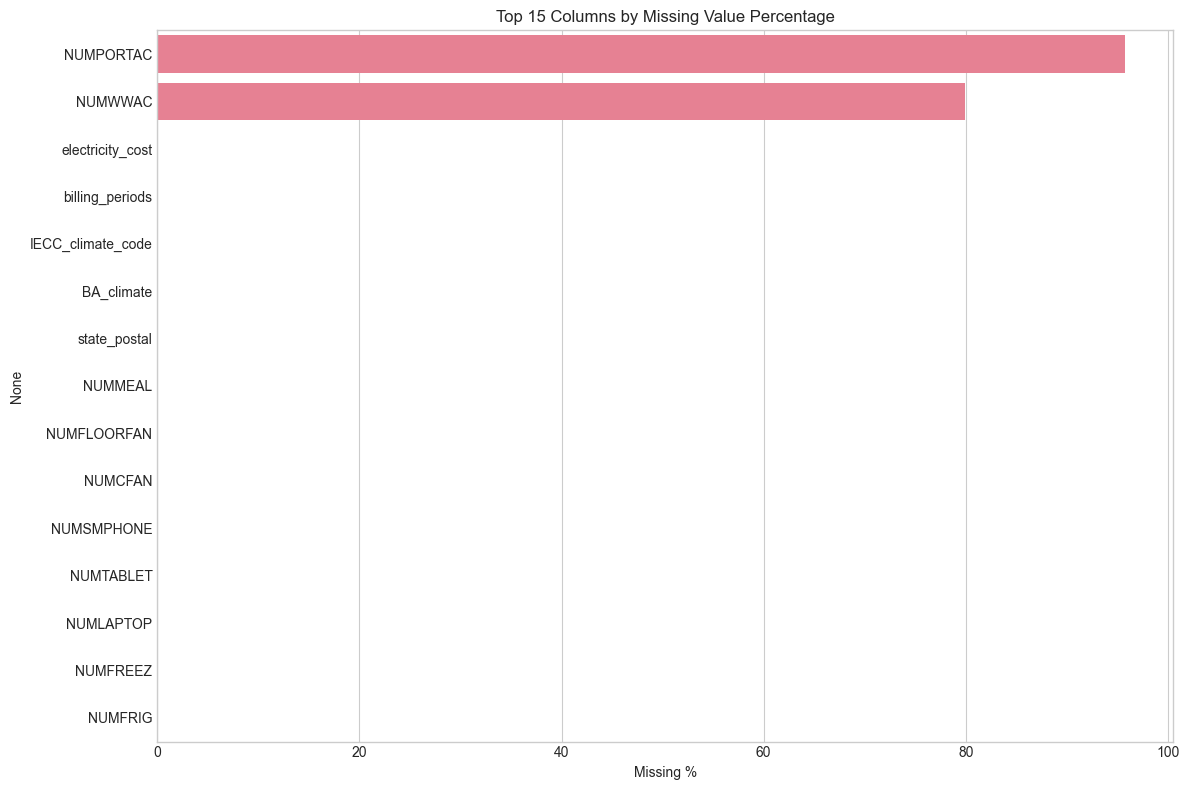

In [50]:
# Calculate missing percentages
missing_pct = df_subset.isna().mean() * 100
missing_pct_sorted = missing_pct.sort_values(ascending=False)

print("Top 15 columns with most missing values:")
display(pd.DataFrame({
    'Column': missing_pct_sorted.head(15).index,
    'Missing %': missing_pct_sorted.head(15).values
}).round(2))

# Visualize missing values
plt.figure(figsize=(12, 8))
sns.barplot(x=missing_pct_sorted.head(15).values, 
            y=missing_pct_sorted.head(15).index)
plt.title('Top 15 Columns by Missing Value Percentage')
plt.xlabel('Missing %')
plt.tight_layout()
plt.show()

In [51]:
# Create missing summary DataFrame for reference
missing_summary = pd.DataFrame({
    'Column': missing_pct_sorted.index,
    'Missing %': missing_pct_sorted.values
})

print("\nMissing value summary:")
print(f"  - Columns with >50% missing: {len(missing_summary[missing_summary['Missing %'] > 50])}")
print(f"  - Columns with >20% missing: {len(missing_summary[missing_summary['Missing %'] > 20])}")
print(f"  - Columns with any missing: {len(missing_summary[missing_summary['Missing %'] > 0])}")


Missing value summary:
  - Columns with >50% missing: 2
  - Columns with >20% missing: 2
  - Columns with any missing: 2


## 5. Cleaning Critical Columns
Certain columns are essential for our analysis. We cannot impute the Target Variable "DOLLAREL" or fundamental housing properties like square footage without introducing significant bias. Rows missing these values are dropped.

In [52]:
# Define critical columns using the NEW names
critical_cols = [TARGET_VAR, "heated_square_footage", "billing_periods", "heating_degree_days", "cooling_degree_days"]
critical_cols = [c for c in critical_cols if c in df_subset.columns]

print("Missing values in critical columns BEFORE cleaning:")
missing_in_critical = df_subset[critical_cols].isna().sum()
display(missing_in_critical)

# Create df_clean by dropping rows with missing critical data
initial_shape = df_subset.shape
df_clean = df_subset.dropna(subset=critical_cols).copy()
print(f"\nDropped {initial_shape[0] - df_clean.shape[0]:,} rows with missing critical data")
print(f"New shape: {df_clean.shape}")
print(f"Rows retained: {df_clean.shape[0]:,} ({df_clean.shape[0]/initial_shape[0]*100:.1f}%)")

Missing values in critical columns BEFORE cleaning:


electricity_cost         0
heated_square_footage    0
billing_periods          0
heating_degree_days      0
cooling_degree_days      0
dtype: int64


Dropped 0 rows with missing critical data
New shape: (18496, 20)
Rows retained: 18,496 (100.0%)


## 6. Imputing Appliance Data
In the RECS dataset, missing values in appliance means absence of that appliance. We impute these NaNs with `0`.

In [53]:
# For appliance counts, NaN likely means 0 appliances
existing_appliance_cols = [c for c in APPLIANCE_COLS if c in df_clean.columns]

print("Imputing missing appliance counts with 0:")
for col in existing_appliance_cols:
    missing_before = df_clean[col].isna().sum()
    if missing_before > 0:
        df_clean.loc[:, col] = df_clean[col].fillna(0)
        print(f"  {col}: {missing_before:,} NaN -> 0")

print(f"Remaining missing values in df_clean: {df_clean.isna().sum().sum()}")
print(f"\nAppliance columns imputed: {len(existing_appliance_cols)}")

Imputing missing appliance counts with 0:
  NUMWWAC: 14,780 NaN -> 0
  NUMPORTAC: 17,703 NaN -> 0
Remaining missing values in df_clean: 0

Appliance columns imputed: 10


## 7. Categorical Variable Processing
We convert categorical features (State, Climate Region) to the correct data type. This way we handle any potential missing values by labeling them as 'Unknown'.

In [54]:
# Convert categorical columns to proper type
for col in categorical_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype('category')
        # Add 'Unknown' category for any remaining missing values
        if df_clean[col].isna().any():
            df_clean[col] = df_clean[col].cat.add_categories(['Unknown']).fillna('Unknown')

print("Categorical columns processed:")
for col in categorical_cols:
    if col in df_clean.columns:
        print(f"  {col}: {df_clean[col].nunique()} categories")

Categorical columns processed:
  state_postal: 51 categories
  BA_climate: 8 categories
  IECC_climate_code: 17 categories


## 8. Feature Engineering
We create new features to improve model performance:
1. Home Size: Consolidating different square footage metrics.
2. Total Appliances: Aggregating device counts to estimate load.
3. Degree Days: Summing Heating (HDD) and Cooling (CDD) degree days for a total climate impact metric.
4. Log Transformation: Applying "log" to the bill amount to normalize the distribution.

In [55]:
# Home size feature
df_clean["home_size"] = df_clean["heated_square_footage"].fillna(df_clean["engineered_total_square_footage"])
print(f"  home_size: {df_clean['home_size'].isna().sum():,} missing values")

# Total appliance count
df_clean["num_appliances"] = df_clean[APPLIANCE_COLS].sum(axis=1)
print(f"  num_appliances: range {df_clean['num_appliances'].min():.0f} to {df_clean['num_appliances'].max():.0f}")

# Temperature features
df_clean["temp_hdd"] = df_clean["heating_degree_days"]
df_clean["temp_cdd"] = df_clean["cooling_degree_days"]
df_clean["temp_degree_days"] = df_clean["heating_degree_days"] + df_clean["cooling_degree_days"]
print(f"  temp_degree_days: mean = {df_clean['temp_degree_days'].mean():.0f}")

# Bill amount features
df_clean["bill_amount"] = df_clean["electricity_cost"]
df_clean["bill_per_period"] = df_clean["electricity_cost"] / df_clean["billing_periods"]
df_clean["month_periods"] = df_clean["billing_periods"]

# Log transformation
df_clean = df_clean[df_clean["bill_amount"] > 0]
df_clean["log_bill_amount"] = np.log(df_clean["bill_amount"])

print(f"\nFeature engineering complete. Final shape: {df_clean.shape}")
print(f"Bill amount range: ${df_clean['bill_amount'].min():.2f} to ${df_clean['bill_amount'].max():.2f}")

  home_size: 0 missing values
  num_appliances: range 0 to 47
  temp_degree_days: mean = 5797

Feature engineering complete. Final shape: (18481, 29)
Bill amount range: $2.85 to $15680.18


## 9. Outlier Detection
We use the Interquartile Range (IQR) method to detect outliers in key variables (Bill Amount, Home Size). While we detect them, we often choose to keep them in energy datasets as high consumption is usually real, for example: large luxury homes rather than being an error.

bill_amount: 616 outliers (3.3%)
home_size: 512 outliers (2.8%)
num_appliances: 247 outliers (1.3%)
temp_degree_days: 355 outliers (1.9%)


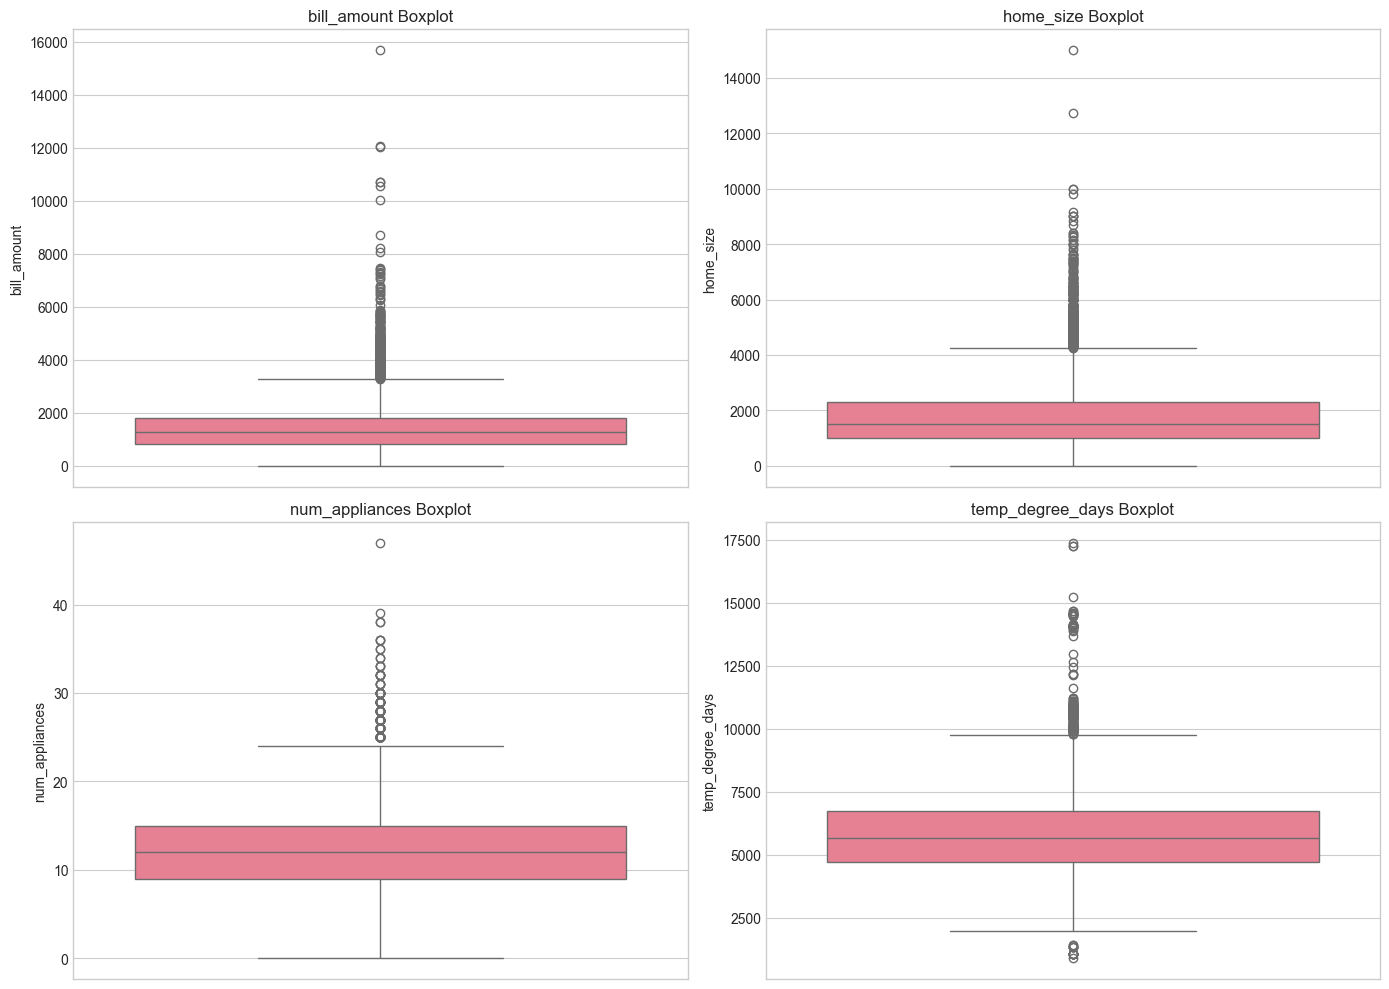

In [56]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Check outliers in key variables
key_vars = ["bill_amount", "home_size", "num_appliances", "temp_degree_days"]

outlier_summary = {}
for var in key_vars:
    outliers, lower, upper = detect_outliers_iqr(df_clean, var)
    outlier_summary[var] = {
        'count': len(outliers),
        'percentage': len(outliers) / len(df_clean) * 100,
        'lower_bound': lower,
        'upper_bound': upper
    }
    print(f"{var}: {len(outliers):,} outliers ({len(outliers)/len(df_clean)*100:.1f}%)")

# Visualize outliers
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for idx, var in enumerate(key_vars):
    row, col = idx // 2, idx % 2
    sns.boxplot(data=df_clean, y=var, ax=axes[row, col])
    axes[row, col].set_title(f'{var} Boxplot')
plt.tight_layout()
plt.show()

## 10. Final Dataset Preparation
Selecting only the engineered features and cleaned categorical variables necessary for the machine learning stage.

In [57]:
# Select final features for modeling
final_features = [
    "bill_amount",
    "log_bill_amount",
    "home_size",
    "num_appliances",
    "temp_hdd",
    "temp_cdd",
    "temp_degree_days",
    "month_periods"
] + categorical_cols

df_final = df_clean[final_features].copy()

print(f"Final dataset shape: {df_final.shape}")
print(f"\nFeature summary:")
print(f"  - Target variable: bill_amount (and log_bill_amount)")
print(f"  - Home size: home_size")
print(f"  - Appliances: num_appliances")
print(f"  - Temperature: temp_hdd, temp_cdd, temp_degree_days")
print(f"  - Time: month_periods")
print(f"  - Context: {len(categorical_cols)} categorical columns")

Final dataset shape: (18481, 11)

Feature summary:
  - Target variable: bill_amount (and log_bill_amount)
  - Home size: home_size
  - Appliances: num_appliances
  - Temperature: temp_hdd, temp_cdd, temp_degree_days
  - Time: month_periods
  - Context: 3 categorical columns


## 11. One-Hot Encoding
Converting categorical variables like State or Climate Code into binary dummy variables. "drop_first=True" is used to prevent multicollinearity.

In [58]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(
    df_final, 
    columns=categorical_cols, 
    drop_first=True,  # Avoid dummy variable trap
    prefix=categorical_cols
)

print(f"Shape after one-hot encoding: {df_encoded.shape}")
print(f"\nSample of encoded features:")
display(df_encoded.head())

Shape after one-hot encoding: (18481, 81)

Sample of encoded features:


,bill_amount,log_bill_amount,home_size,num_appliances,temp_hdd,temp_cdd,temp_degree_days,month_periods,state_postal_AL,state_postal_AR,...,IECC_climate_code_4B,IECC_climate_code_4C,IECC_climate_code_5A,IECC_climate_code_5B,IECC_climate_code_6A,IECC_climate_code_6B,IECC_climate_code_7A,IECC_climate_code_7AK,IECC_climate_code_7B,IECC_climate_code_8AK
0,1955.06,7.578176,2100,15.0,3844,1679,5523,1,False,False,...,True,False,False,False,False,False,False,False,False,False
1,713.27,6.569860,590,8.0,3766,1458,5224,1,False,True,...,False,False,False,False,False,False,False,False,False,False
2,334.51,5.812667,900,4.0,3819,1696,5515,5,False,False,...,True,False,False,False,False,False,False,False,False,False
3,1424.86,7.261829,2100,12.0,2614,1718,4332,1,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1087.00,6.991177,800,9.0,4219,1363,5582,1,False,False,...,False,False,False,False,False,False,False,False,False,False


## 12. Correlation Analysis
Analyzing how strongly features correlate with the Electricity Bill.
A heatmap will provides a visual representation of these relationships.

Top 15 features correlated with bill_amount:


bill_amount         1.000000
log_bill_amount     0.885144
num_appliances      0.394182
home_size           0.350421
temp_cdd            0.142261
temp_degree_days   -0.049412
month_periods      -0.100280
temp_hdd           -0.103170
Name: bill_amount, dtype: float64


Bottom 10 features correlated with bill_amount:


bill_amount         1.000000
log_bill_amount     0.885144
num_appliances      0.394182
home_size           0.350421
temp_cdd            0.142261
temp_degree_days   -0.049412
month_periods      -0.100280
temp_hdd           -0.103170
Name: bill_amount, dtype: float64

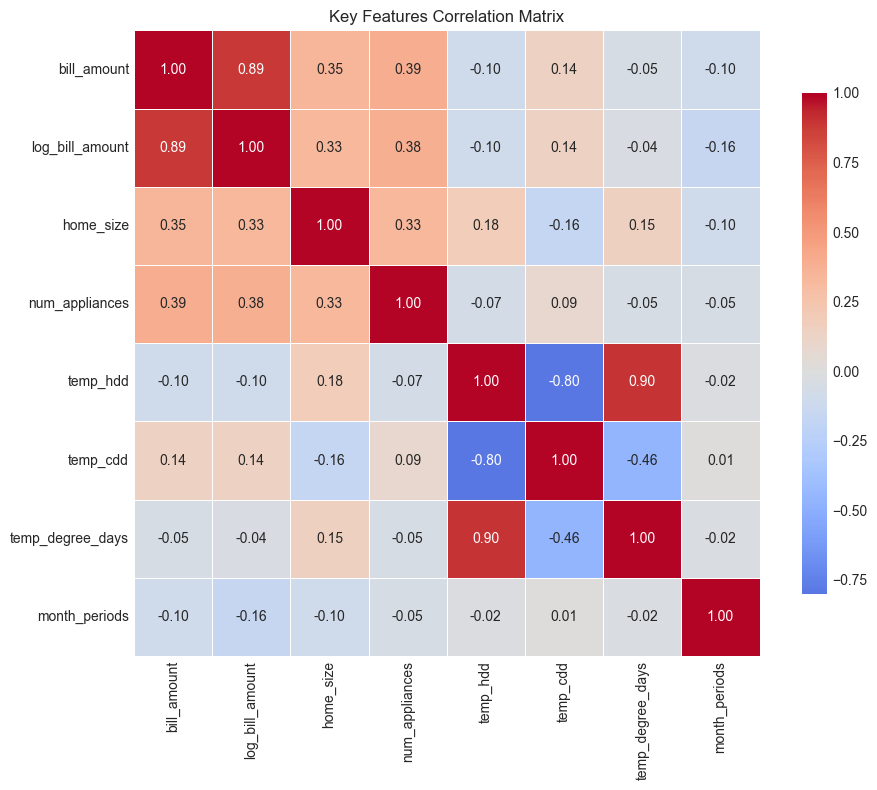


Note: Full correlation matrix has 8 features (too large to visualize).
Showing correlation for 8 key engineered features only.


In [60]:
# Calculate correlations with target variable
numeric_features = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
correlations = df_encoded[numeric_features].corr()['bill_amount'].sort_values(ascending=False)

print("Top 15 features correlated with bill_amount:")
display(correlations.head(15))

print("\nBottom 10 features correlated with bill_amount:")
display(correlations.tail(10))

# Visualize correlation matrix for KEY FEATURES ONLY (not all one-hot encoded features)
key_features_for_corr = ['bill_amount', 'log_bill_amount', 'home_size', 'num_appliances', 
                         'temp_hdd', 'temp_cdd', 'temp_degree_days', 'month_periods']
key_features_for_corr = [f for f in key_features_for_corr if f in df_encoded.columns]

plt.figure(figsize=(10, 8))
corr_matrix_key = df_encoded[key_features_for_corr].corr()
sns.heatmap(
    corr_matrix_key,
    annot=True, 
    cmap='coolwarm', 
    center=0,
    square=True,
    fmt='.2f',
    cbar_kws={"shrink": 0.8},
    linewidths=0.5
)
plt.title('Key Features Correlation Matrix')
plt.tight_layout()
plt.show()

print(f"\nNote: Full correlation matrix has {len(numeric_features)} features (too large to visualize).")
print(f"Showing correlation for {len(key_features_for_corr)} key engineered features only.")

## 13. Distribution Analysis
Visualizing the distributions of key variables.

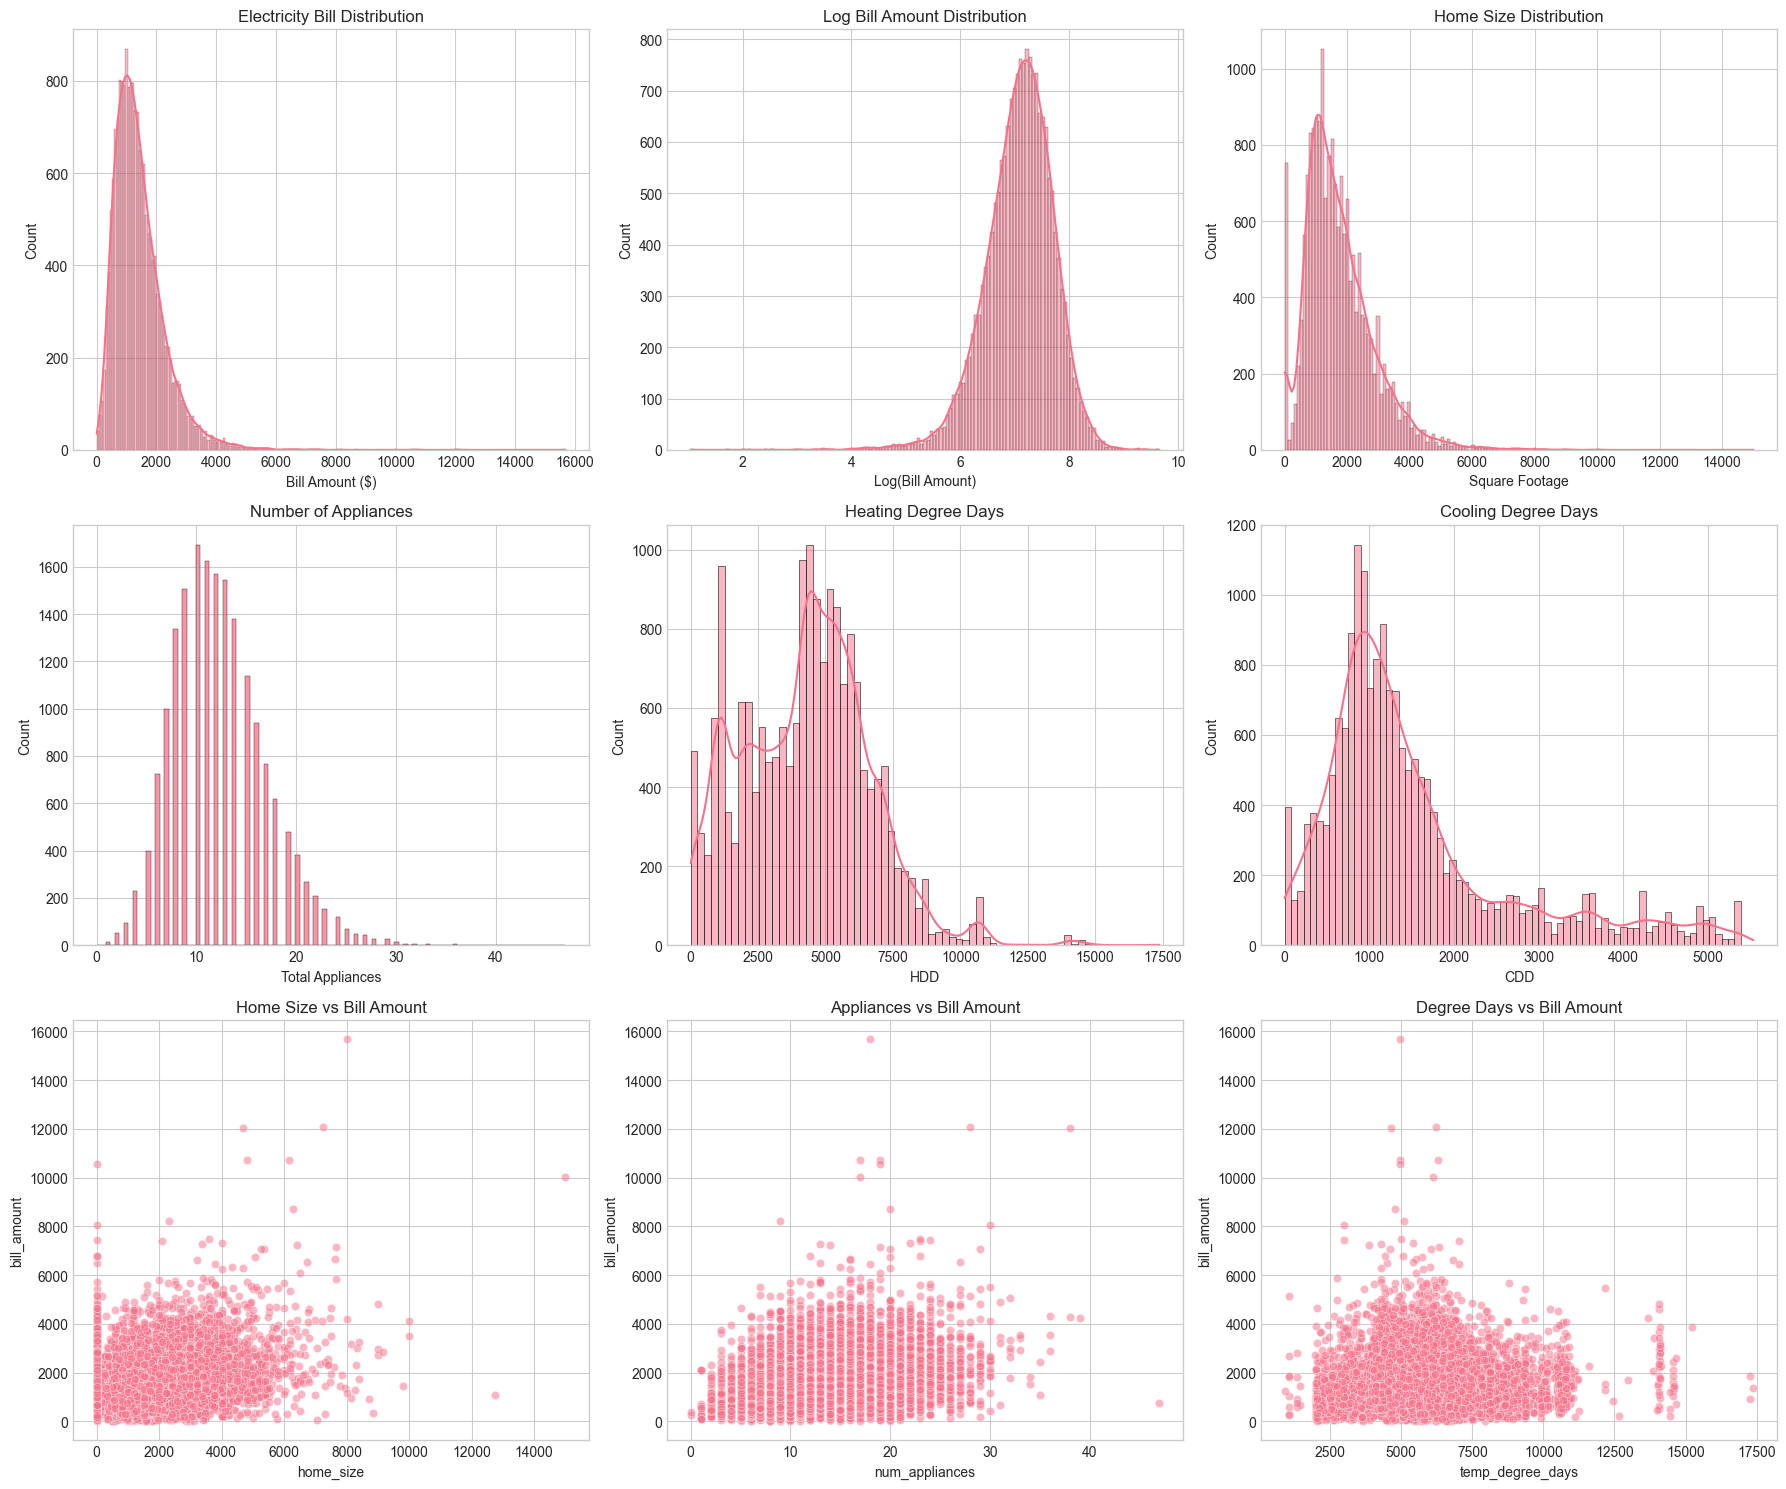

In [61]:
# Plot distributions of key features
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Bill amount
sns.histplot(df_clean['bill_amount'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Electricity Bill Distribution')
axes[0, 0].set_xlabel('Bill Amount ($)')

# Log bill amount
sns.histplot(df_clean['log_bill_amount'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Log Bill Amount Distribution')
axes[0, 1].set_xlabel('Log(Bill Amount)')

# Home size
sns.histplot(df_clean['home_size'], kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Home Size Distribution')
axes[0, 2].set_xlabel('Square Footage')

# Number of appliances
sns.histplot(df_clean['num_appliances'], kde=False, ax=axes[1, 0])
axes[1, 0].set_title('Number of Appliances')
axes[1, 0].set_xlabel('Total Appliances')

# Temperature features (UPDATED NAMES HERE)
sns.histplot(df_clean['temp_hdd'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Heating Degree Days')
axes[1, 1].set_xlabel('HDD')

sns.histplot(df_clean['temp_cdd'], kde=True, ax=axes[1, 2])
axes[1, 2].set_title('Cooling Degree Days')
axes[1, 2].set_xlabel('CDD')

# Scatter: Home size vs Bill
sns.scatterplot(data=df_clean, x='home_size', y='bill_amount', alpha=0.5, ax=axes[2, 0])
axes[2, 0].set_title('Home Size vs Bill Amount')

# Scatter: Appliances vs Bill
sns.scatterplot(data=df_clean, x='num_appliances', y='bill_amount', alpha=0.5, ax=axes[2, 1])
axes[2, 1].set_title('Appliances vs Bill Amount')

# Scatter: Degree days vs Bill
sns.scatterplot(data=df_clean, x='temp_degree_days', y='bill_amount', alpha=0.5, ax=axes[2, 2])
axes[2, 2].set_title('Degree Days vs Bill Amount')

plt.tight_layout()
plt.show()

## 14. Summary Statistics
Final check of the statistics of our clean dataset before saving it.

In [62]:
print("Dataset Summary:")
print(f"  - Total households: {len(df_clean):,}")
print(f"  - Features: {len(df_encoded.columns)}")
print(f"  - Memory usage: {df_encoded.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nTarget variable (bill_amount) statistics:")
print(df_clean['bill_amount'].describe())

print("\nKey features statistics:")
summary_stats = df_clean[['home_size', 'num_appliances', 'temp_degree_days', 'month_periods']].describe()
display(summary_stats)

Dataset Summary:
  - Total households: 18,481
  - Features: 81
  - Memory usage: 2.56 MB

Target variable (bill_amount) statistics:
count    18481.000000
mean      1426.066464
std        861.277417
min          2.850000
25%        837.330000
50%       1258.600000
75%       1819.120000
max      15680.180000
Name: bill_amount, dtype: float64

Key features statistics:


,home_size,num_appliances,temp_degree_days,month_periods
count,18481.000000,18481.000000,18481.000000,18481.000000
mean,1743.872626,12.349224,5797.229208,1.566582
std,1106.204338,4.665999,1571.644012,1.374913
min,0.000000,0.000000,896.000000,1.000000
25%,1000.000000,9.000000,4698.000000,1.000000
50%,1520.000000,12.000000,5648.000000,1.000000
75%,2300.000000,15.000000,6728.000000,1.000000
max,15000.000000,47.000000,17383.000000,5.000000


## 15. Exporting Data
Saving the processed dataset to CSV.
* cleaned_energy_data.csv: The final, encoded file ready for ML models.
* cleaned_energy_data.csv_intermediate.csv: A readable version before One-Hot Encoding.

In [63]:
# Save the fully processed dataset
output_filename = "cleaned_energy_data.csv"
df_encoded.to_csv(output_filename, index=False)

print(f"Cleaned dataset saved to: {output_filename}")
print(f"- Shape: {df_encoded.shape}")
print(f"- Ready for machine learning training")

# Also save a version with original bill amount for reference
df_clean.to_csv("cleaned_energy_data_intermediate.csv", index=False)
print(f"Intermediate dataset also saved for traceability")

Cleaned dataset saved to: cleaned_energy_data.csv
- Shape: (18481, 81)
- Ready for machine learning training
Intermediate dataset also saved for traceability


## 16. Data Quality Final Check
Comprehensive validation before model training.

In [65]:
# 1. Check for any remaining missing values
print("\n1. MISSING VALUES CHECK:")
missing_count = df_encoded.isna().sum().sum()
if missing_count == 0:
    print("No missing values in final dataset")
else:
    print(f"WARNING: {missing_count} missing values found!")
    print(df_encoded.isna().sum()[df_encoded.isna().sum() > 0])

# 2. Check for infinite values
print("\n2. INFINITE VALUES CHECK:")
inf_count = np.isinf(df_encoded.select_dtypes(include=[np.number])).sum().sum()
if inf_count == 0:
    print("No infinite values in dataset")
else:
    print(f"WARNING: {inf_count} infinite values found!")

# 3. Check for duplicate rows
print("\n3. DUPLICATE ROWS CHECK:")
dup_count = df_encoded.duplicated().sum()
if dup_count == 0:
    print("No duplicate rows")
else:
    print(f"{dup_count} duplicate rows found ({dup_count/len(df_encoded)*100:.2f}%)")

# 4. Target variable check
print("\n4. TARGET VARIABLE CHECK:")
print(f"- Min bill amount: ${df_encoded['bill_amount'].min():.2f}")
print(f"- Max bill amount: ${df_encoded['bill_amount'].max():.2f}")
print(f"- Mean bill amount: ${df_encoded['bill_amount'].mean():.2f}")
print(f"- Median bill amount: ${df_encoded['bill_amount'].median():.2f}")
if df_encoded['bill_amount'].min() > 0:
    print("All bill amounts are positive")

# 5. Feature count
print("\n5. FEATURE SUMMARY:")
print(f"- Total features: {df_encoded.shape[1]}")
print(f"- Numeric features: {len(df_encoded.select_dtypes(include=[np.number]).columns)}")
print(f"- Total samples: {df_encoded.shape[0]:,}")

# 6. Data types check
print("\n6. DATA TYPES:")
print(df_encoded.dtypes.value_counts())

print("DATA QUALITY CHECK COMPLETE - Ready for ML Training")


1. MISSING VALUES CHECK:
No missing values in final dataset

2. INFINITE VALUES CHECK:
No infinite values in dataset

3. DUPLICATE ROWS CHECK:
No duplicate rows

4. TARGET VARIABLE CHECK:
- Min bill amount: $2.85
- Max bill amount: $15680.18
- Mean bill amount: $1426.07
- Median bill amount: $1258.60
All bill amounts are positive

5. FEATURE SUMMARY:
- Total features: 81
- Numeric features: 8
- Total samples: 18,481

6. DATA TYPES:
bool       73
int64       5
float64     3
Name: count, dtype: int64
DATA QUALITY CHECK COMPLETE - Ready for ML Training
